In [1]:
!git clone https://github.com/d-t-n/quality-inspection-ai-cv-deep-learning/

Cloning into 'quality-inspection-ai-cv-deep-learning'...
remote: Enumerating objects: 8700, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 8700 (delta 56), reused 66 (delta 26), pack-reused 8600 (from 1)
Receiving objects: 100% (8700/8700), 100.28 MiB | 41.76 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
%cd quality-inspection-ai-cv-deep-learning

/kaggle/working/quality-inspection-ai-cv-deep-learning


In [3]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

Dataset URL: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 97%|██████████████████████████████████████▊ | 97.0M/100M [00:00<00:00, 191MB/s]
100%|█████████████████████████████████████████| 100M/100M [00:00<00:00, 174MB/s]


In [4]:
!unzip real-life-industrial-dataset-of-casting-product.zip -d casting_data/

Archive:  real-life-industrial-dataset-of-casting-product.zip
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_0.jpeg  
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_100.jpeg  
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_1015.jpeg  
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_102.jpeg  
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_1046.jpeg  
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_1053.jpeg  
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_1055.jpeg  
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_1077.jpeg  
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_1087.jpeg  
  inflating: casting_data/casting_512x512/casting_512x512/def_front/cast_def_0_1091.jpeg  
  inflating: casting_data/casting

In [5]:
!jupyter nbconvert --to notebook --execute Model2-Xception-QC.ipynb

[NbConvertApp] Converting notebook Model2-Xception-QC.ipynb to notebook
I0000 00:00:1727877942.661783     184 service.cc:145] XLA service 0x7dac98008260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727877942.661869     184 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-02 14:05:51.603902: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[36,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-02 14:05:51.791189: E external/local_xla/xla/service/slow_ope

In [6]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image 
from keras.models import Sequential
from sklearn import metrics

In [7]:
# defining dir variables 
root_dir = 'archive/casting_data/casting_data/'
train_defective = root_dir + 'train/def_front/'
train_ok = root_dir + 'train/ok_front/'

test_defective = root_dir + 'test/def_front/'
test_ok = root_dir + 'test/ok_front/'

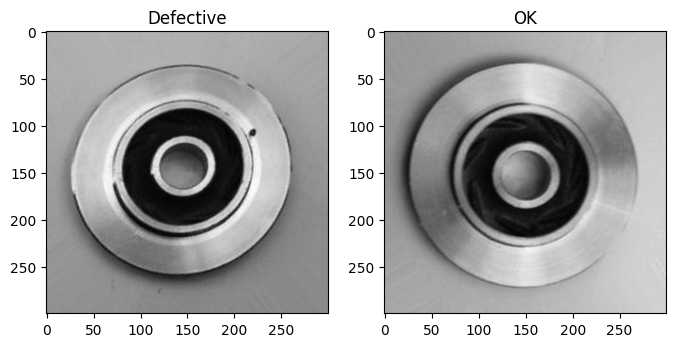

In [8]:
# Ploting images

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(plt.imread(train_defective+os.listdir(train_defective)[0]))
axes[1].imshow(plt.imread(train_ok+os.listdir(train_ok)[0]))
axes[0].set_title('Defective')
axes[1].set_title('OK')
plt.show()

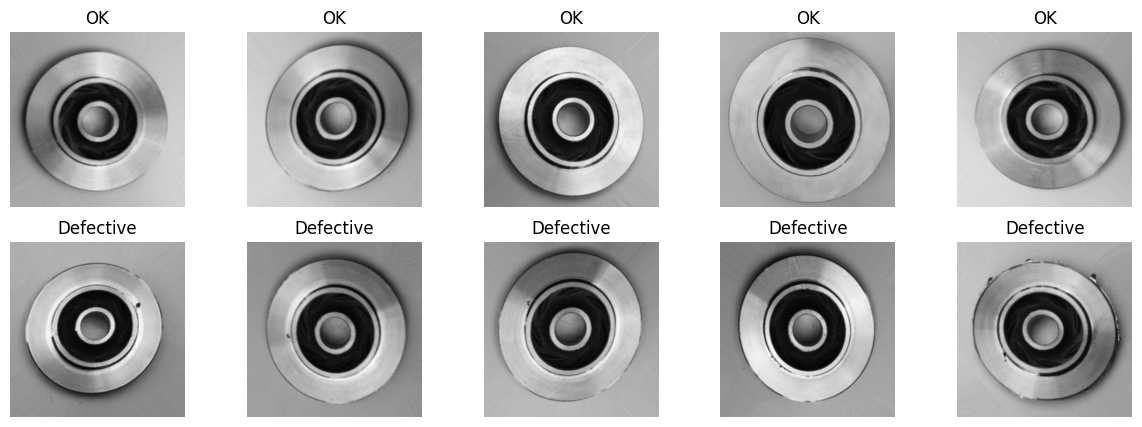

In [9]:
# 5 images from each label - training set

# define the number of images to plot for each label
num_images = 5

# create a figure with two rows and num_images columns
fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(15,5))

# plot the ok images
for i, filename in enumerate(os.listdir(train_ok)[:num_images]):
    img = plt.imread(train_ok + filename)
    axs[0,i].imshow(img)
    axs[0,i].set_title('OK')
    axs[0,i].axis('off')

# plot the defective images
for i, filename in enumerate(os.listdir(train_defective)[:num_images]):
    img = plt.imread(train_defective + filename)
    axs[1,i].imshow(img)
    axs[1,i].set_title('Defective')
    axs[1,i].axis('off')

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# show the plot
plt.show()

# EDA

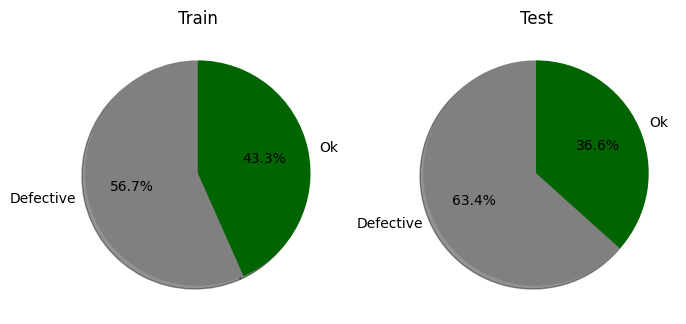

 Defective Training Images 	: 3758
 Ok Training Images 		: 2875

 Defective Testing Images 	: 453
 Ok Testing Images 		: 262


In [10]:
x_train = np.array([len(os.listdir(train_defective)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_defective)),len(os.listdir(test_ok))])
label = ['Defective','Ok']
colors = ['grey', 'darkgreen']
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

print(' Defective Training Images \t: ' + str(len(os.listdir(train_defective))))
print(' Ok Training Images \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Defective Testing Images \t: ' + str(len(os.listdir(test_defective))))
print(' Ok Testing Images \t\t: ' + str(len(os.listdir(test_ok))))

In [11]:

# Using IDG to load images from directory
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30 percent validation split for taining 
test_idg = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size = (300, 300)
batch_size = 64

arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
test  = test_idg.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## Xception

In [12]:
from tensorflow.keras.applications import Xception
xcept = Xception(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [13]:
import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in xcept.layers:
    layer.trainable = False

cnn = keras.Sequential([
    xcept,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnn.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
history = cnn.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


I0000 00:00:1727878966.140798     483 service.cc:145] XLA service 0x7a037c00f2f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727878966.140844     483 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727878966.140848     483 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-10-02 14:22:57.437539: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[64,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-02 14:22:58.42506

20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6158 - loss: 16.6841 - val_accuracy: 0.8225 - val_loss: 2.1568
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8707 - loss: 1.6109 - val_accuracy: 0.9472 - val_loss: 0.6201
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9537 - loss: 0.5022 - val_accuracy: 0.9859 - val_loss: 0.0681
Epoch 4/20
11/20 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.9857 - loss: 0.0629

2024-10-02 14:24:48.486168: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[36,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-02 14:24:48.689910: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.203837662s
Trying algorithm eng3{k11=2} for conv (f32[36,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queu

20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9854 - loss: 0.0846 - val_accuracy: 0.9910 - val_loss: 0.0848
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9908 - loss: 0.0534 - val_accuracy: 0.9930 - val_loss: 0.0574
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9889 - loss: 0.0770 - val_accuracy: 0.9910 - val_loss: 0.0455
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9952 - loss: 0.0482 - val_accuracy: 0.9920 - val_loss: 0.0474
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 948ms/step - accuracy: 0.9962 - loss: 0.0123 - val_accuracy: 0.9930 - val_loss: 0.0526
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9902 - loss: 0.0531 - val_accuracy: 0.9889 - val_loss: 0.0400
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9886 - loss: 0.0310 - val_accuracy: 0.9940 - val_loss: 0.0424
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9895 - loss: 0.0277 - val_accuracy: 0.9945 - val_loss: 0.031

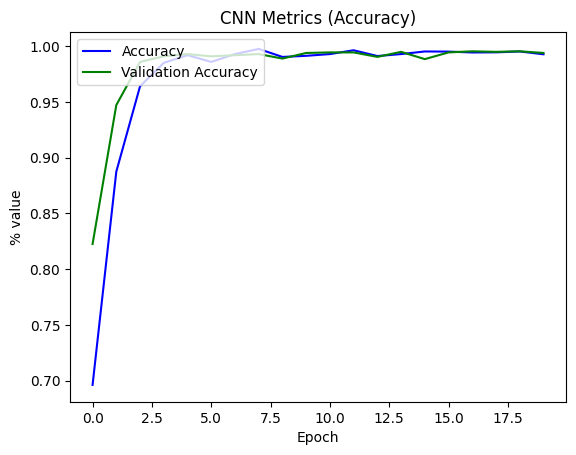

In [15]:
plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

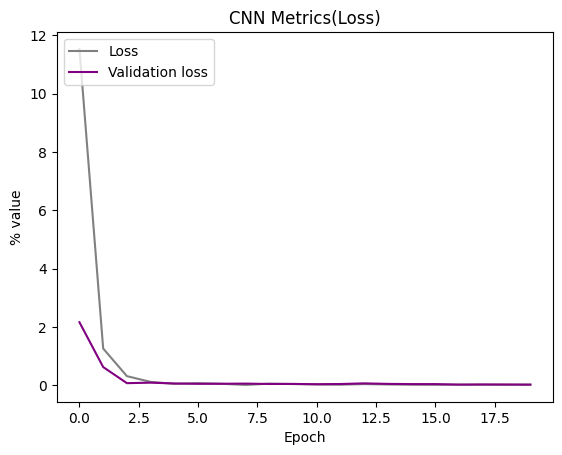

In [16]:
plt.plot(history.history['loss'], color='grey', label='Loss')
plt.plot(history.history['val_loss'], color='purple', label='Validation loss')
plt.title('CNN Metrics(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [17]:
y_pred = cnn.predict(test)
y_pred = (y_pred >= 0.5).reshape(-1,)

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 


In [18]:
y_actual = test.classes[test.index_array]

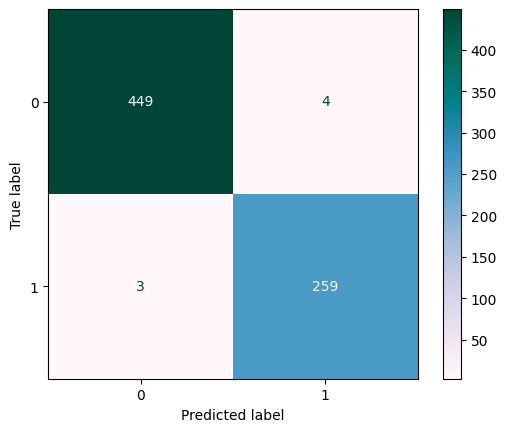

In [19]:
cm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='PuBuGn')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9934    0.9912    0.9923       453
           1     0.9848    0.9885    0.9867       262

    accuracy                         0.9902       715
   macro avg     0.9891    0.9899    0.9895       715
weighted avg     0.9902    0.9902    0.9902       715



## Inception Resnet V2

In [24]:
from tensorflow.keras.applications import InceptionResNetV2
IncResNV2 = InceptionResNetV2(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [25]:
import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in IncResNV2.layers:
    layer.trainable = False

cnn = keras.Sequential([
    IncResNV2,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnn.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

In [26]:
history = cnn.fit(
    train,
    steps_per_epoch=50,
    validation_data=valid,
    epochs=20
    )

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.6079 - loss: 14.2950 - val_accuracy: 0.9296 - val_loss: 0.3085
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 582ms/step - accuracy: 0.9567 - loss: 0.1984 - val_accuracy: 0.9829 - val_loss: 0.0627
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 853ms/step - accuracy: 0.9869 - loss: 0.0377 - val_accuracy: 0.9915 - val_loss: 0.0347
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.9961 - loss: 0.0373 - val_accuracy: 0.9915 - val_loss: 0.0296
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 853ms/step - accuracy: 0.9946 - loss: 0.0208 - val_accuracy: 0.9839 - val_loss: 0.0474
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 571ms/step - accuracy: 0.9946 - loss: 0.0257 - val_accuracy: 0.9940 - val_loss: 0.0272
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 854ms/step - accuracy: 0.9974 - loss: 0.0159 - val_accuracy: 0.9920 - val_loss: 0.0330
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.9969 - loss: 0.0145 - val_accur

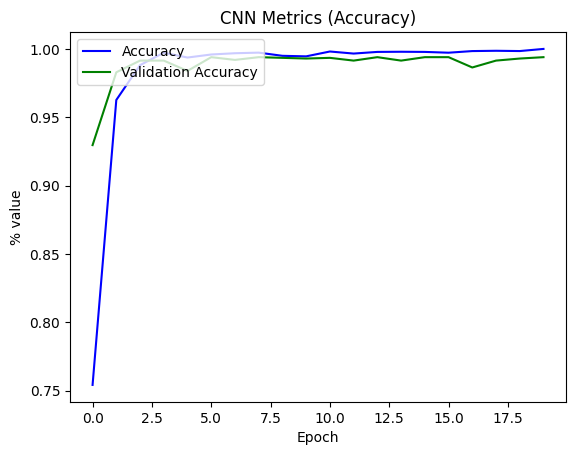

In [27]:
plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

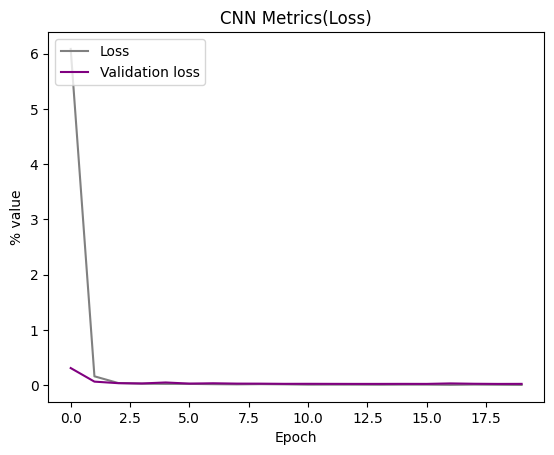

In [28]:
plt.plot(history.history['loss'], color='grey', label='Loss')
plt.plot(history.history['val_loss'], color='purple', label='Validation loss')
plt.title('CNN Metrics(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [29]:
y_pred = cnn.predict(test)
y_pred = (y_pred >= 0.5).reshape(-1,)

12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step 


In [30]:
y_actual = test.classes[test.index_array]

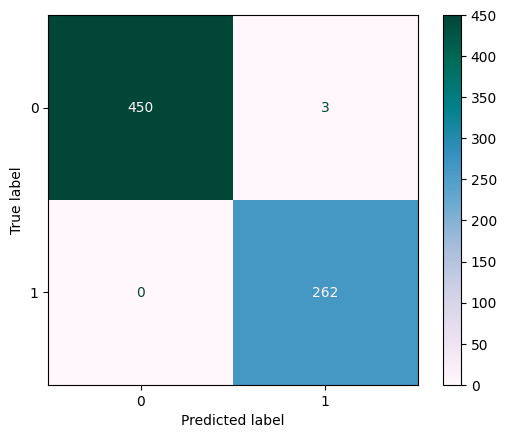

In [31]:
cm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='PuBuGn')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9934    0.9967       453
           1     0.9887    1.0000    0.9943       262

    accuracy                         0.9958       715
   macro avg     0.9943    0.9967    0.9955       715
weighted avg     0.9959    0.9958    0.9958       715



## MobileNet

In [45]:
train_idgm = ImageDataGenerator(rescale=1./255, validation_split=0.3)
test_idgm = ImageDataGenerator(rescale=1./255)

img_sizem = (300, 300)
batch_sizem = 64

arg_trainm = {'target_size': img_sizem,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizem}
arg_testm = {'target_size': img_sizem,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizem,
            'shuffle': False}

trainm = train_idgm.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validm = train_idgm.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testm  = test_idgm.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [46]:
from tensorflow.keras.applications import MobileNet
mobilenet = MobileNet(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [47]:
import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in mobilenet.layers:
    layer.trainable = False

cnnm = keras.Sequential([
    mobilenet,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnnm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


cnnm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [48]:
historym = cnnm.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 665ms/step - accuracy: 0.6035 - loss: 16.6885 - val_accuracy: 0.9633 - val_loss: 0.2236
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 464ms/step - accuracy: 0.9239 - loss: 0.4956 - val_accuracy: 0.9839 - val_loss: 0.1207
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 907ms/step - accuracy: 0.9889 - loss: 0.0366 - val_accuracy: 0.9904 - val_loss: 0.0499
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.9915 - loss: 0.0342 - val_accuracy: 0.9899 - val_loss: 0.0266
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - accuracy: 0.9908 - loss: 0.0300 - val_accuracy: 0.9935 - val_loss: 0.0263
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - accuracy: 0.9867 - loss: 0.0401 - val_accuracy: 0.9940 - val_loss: 0.0182
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 442ms/step - accuracy: 0.9968 - loss: 0.0155 - val_accuracy: 0.9930 - val_loss: 0.0237
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.9970 - loss: 0.0069 - val_accuracy

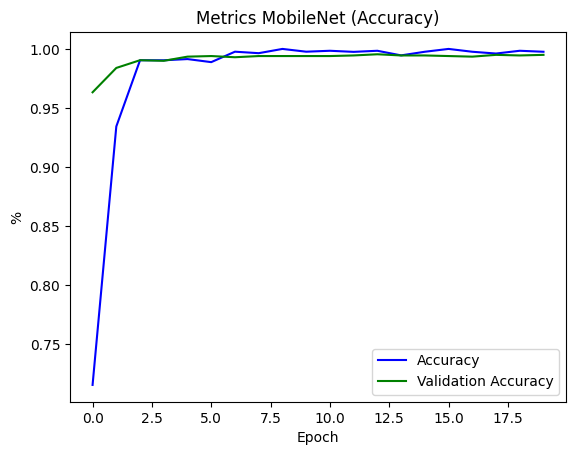

In [52]:
plt.plot(historym.history['accuracy'], color='blue', label='Accuracy')
plt.plot(historym.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('Metrics MobileNet (Accuracy)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

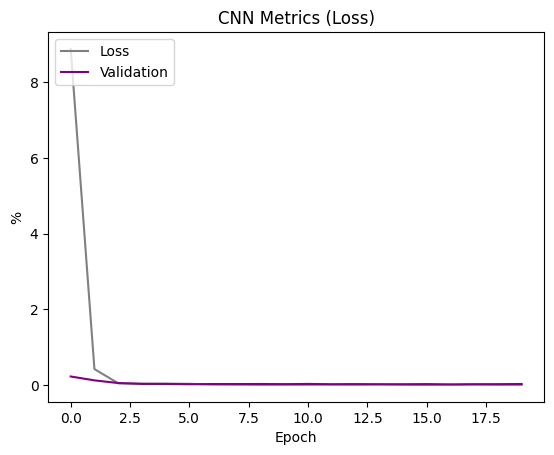

In [54]:
plt.plot(historym.history['loss'], color='grey', label='Loss')
plt.plot(historym.history['val_loss'], color='purple', label='Validation')
plt.title('CNN Metrics (Loss)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

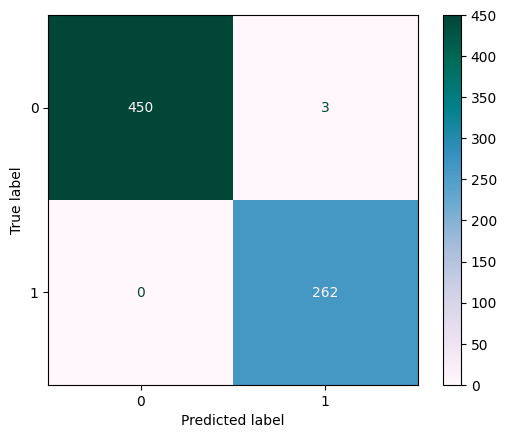

In [55]:
cnnm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmm)
disp.plot(cmap='PuBuGn')
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9934    0.9967       453
           1     0.9887    1.0000    0.9943       262

    accuracy                         0.9958       715
   macro avg     0.9943    0.9967    0.9955       715
weighted avg     0.9959    0.9958    0.9958       715

